In [1]:
from __future__ import division
import pylab as plt
from numpy import random,argwhere,linspace
import numpy as np
%matplotlib inline

In [2]:
velocities = [-0.5, 0.0, 0.5]
probabilities = [0.3, 0.3, 0.4]

def update(x):
    i = argwhere(random.multinomial(1,probabilities))[0][0]
    v = velocities[i]
    x.append(x[-1]+v*dt) # append new position

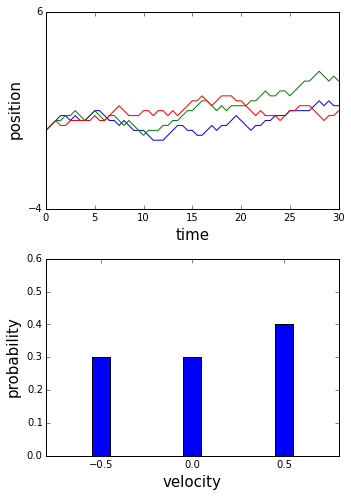

In [3]:
dt = 0.5   # time step
tmax = 30  # simulation for ten seconds

plt.figure(figsize=(5,7))
plt.subplot(2,1,1)
for i in range(3):
    x = [0]  # initial position
    t = 0    # initial time
    while t < tmax:
        t += dt
        update(x)
    plt.plot(linspace(0,tmax,len(x)),x)
plt.yticks([-4,6])
plt.xlabel('time',fontsize=15)
plt.ylabel('position',fontsize=15)

plt.subplot(2,1,2)
plt.bar(velocities,probabilities,width=0.1,align='center')
plt.ylim([0,0.6])
plt.xticks(velocities)
plt.xlim([-0.8,0.8])
plt.xlabel('velocity',fontsize=15)
plt.ylabel('probability',fontsize=15)
plt.tight_layout()
plt.savefig('panelB.svg')
plt.show()

In [4]:
dt = 0.5   # time step
tmax = 30  # simulation for 30 seconds
X = []     # all trajectories
N = 1000   # number of molecules/trajectories

for i in range(N):
    x = [0]  # initial position
    t = 0    # initial time
    while t < tmax:
        t += dt
        update(x)
    X.append(x)

X = np.array(X).T # each column of X is a trajectory

In [5]:
nt = X.shape[0]               # number of time samples
t = linspace(0,tmax,nt)       # time axis
dx = 1                        # compartment length
d0,d1 = -4.5,4.5              # ends of the cable
Bx = np.arange(d0,d1+0.1,dx)  # compartment borders
Bxc = Bx[:-1]+(dx/2)          # compartment centers
Cx = np.empty((nt,len(Bx)-1)) # concentration in each compartment
nC = Cx.shape[1]              # number of compartments

for i in range(nC):
    Cx[:,i] = np.sum((X > Bx[i]) & (X <= Bx[i+1]),axis=1)/N

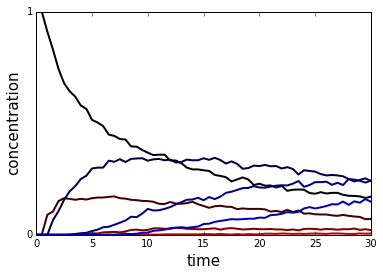

In [6]:
# concentration traces
def plot_conc_trace(data):
    col1 = np.vstack((np.linspace(1,0,(nC+1)/2), np.zeros((nC+1)/2), np.zeros((nC+1)/2)))
    col2 = np.vstack((np.zeros((nC+1)/2), np.zeros((nC+1)/2), np.linspace(0,1,(nC+1)/2)))
    cols = np.hstack((col1[:,:-1],col2))
    for i in range(nC):
        if (i > 0) and (i < (nC-1)): # ignore last two compartments
            plt.plot(t,data[:,i],color=cols[:,i],lw=2)
    plt.yticks([0,1])
    plt.xlabel('time',fontsize=15)
    plt.ylabel('concentration',fontsize=15)

plot_conc_trace(Cx)
plt.savefig('panelC1.svg')

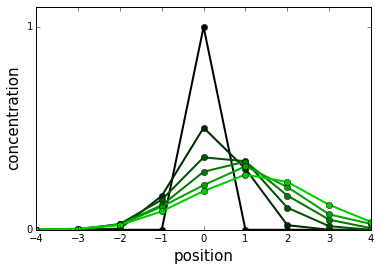

In [7]:
# spatial profile evolution
def plot_conc_profile(data):
    tp = range(1,nt,10)
    cols = np.vstack((np.zeros(len(tp)), np.linspace(0,0.8,len(tp)), np.zeros(len(tp))))
    for (c,i) in enumerate(tp):
        plt.plot(Bxc,data[i,:],'o-',color=cols[:,c],lw=2)
    plt.yticks([0,1])
    plt.ylim([0,1.1])
    plt.xlabel('position',fontsize=15)
    plt.ylabel('concentration',fontsize=15)

plot_conc_profile(Cx)
plt.savefig('panelC2.svg')

In [8]:
from scipy.linalg import expm

def make_matrix(a_,b_):
    # transport rate constants
    a = np.ones(nC-1)*a_
    b = np.ones(nC-1)*b_

    # construct state-transistion matrix, A
    mid = np.zeros(nC)
    mid[:-1] -= a
    mid[1:]  -= b
    return np.diag(a, -1) + np.diag(mid) + np.diag(b, 1)

def simulate(A):
    # initial condition
    u0 = np.zeros(nC)
    u0[(nC-1)/2] = 1.0
    
    # simulate
    u = [] # trace
    for (i,tt) in enumerate(t):
        u.append(np.dot(expm(A*tt),u0))
    return np.array(u)

def f(x,make_plot=False):
    A = make_matrix(x[0],x[1])
    u = simulate(A)
    
    if make_plot:
        print A
        plt.plot(t,u)
        plt.show()
    
    return np.sum((u-Cx)**2)

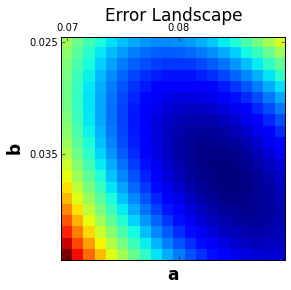

In [9]:
ag = np.arange(0.07, 0.09, 0.001)
bg = np.arange(0.025, 0.045, 0.001)
AG, BG = np.meshgrid(ag, bg)
Z = np.empty(AG.shape)

for i in range(AG.shape[0]):
    for j in range(AG.shape[1]):
        Z[i,j] = f([AG[i,j],BG[i,j]])

plt.matshow(Z)
dtic = 10
atick = ag[::dtic]
btick = bg[::dtic]
plt.xticks(range(0,len(ag),dtic),atick)
plt.yticks(range(0,len(bg),dtic),btick)
plt.ylabel('b',fontsize=17,fontweight='bold')
plt.xlabel('a',fontsize=17,fontweight='bold')
plt.title('Error Landscape',fontsize=17)
plt.show()

In [10]:
from scipy.optimize import minimize
sol = minimize(f,[0.08,0.35])
a_opt,b_opt = sol.x
u_opt = simulate(make_matrix(a_opt,b_opt))

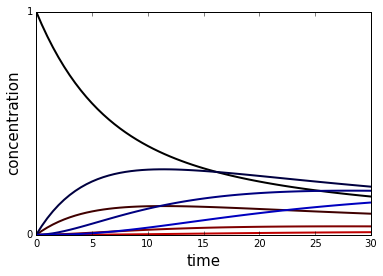

In [11]:
plot_conc_trace(u_opt)
plt.savefig('panelD1.svg')

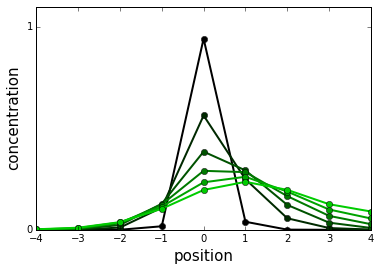

In [12]:
plot_conc_profile(u_opt)
plt.savefig('panelD2.svg')